# D4 transform

Geomatric transforms are the most widely used augmentations. Mainly becase they do not get data outside of the original data distribution and because they "They make intuitive sense". 


**[D4](https://albumentations.ai/docs/api_reference/full_reference/?h=d4#albumentations.augmentations.geometric.transforms.D4)** transform maps orignal image to one of 8 states. 

- `e` - identity. The original image
- `r90` - rotation by 90 degrees
- `r180` - rotation by 180 degrees, which is equal to `v * h = h * v`
- `r270` - rotation by 270 degrees
- `v` - vertical flip
- `hvt` - reflection across anti diagonal, which is equal to `t * v * h` or `t * rot180` 
- `h` - horizonal flip
- `t` - reflection actoss the diagonal

The same transform could be represented as 

```python
A.Compose([A.HorizonatalFlip(p=0.5), A.RandomRotate90(p=1)])
```
Hence this is just a convenient notation.

The transform is useful in situations where imagery data does not have preferred orientation:

For example:
- medical images
- top view drone and satellite imagery

Works for:
- image
- mask
- keypoints
- bounding boxes

In [ ]:
%matplotlib inline

In [ ]:
import json

In [ ]:
import hashlib

In [ ]:
import albumentations as A
import cv2
from matplotlib import pyplot as plt

In [ ]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)
KEYPOINT_COLOR = (0, 255, 0)

In [ ]:
def visualize_bbox(img, bbox, class_name, bbox_color=BOX_COLOR, thickness=1):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = (int(x) for x in bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=bbox_color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), bbox_color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=3):
    image = image.copy()
    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, color, -1)
    return image

In [ ]:
def visualize_one(image, bboxes, keypoints, category_ids, category_id_to_name, mask):
    # Create a copy of the image to draw on
    img = image.copy()

    # Apply each bounding box and corresponding category ID
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)

    # Apply keypoints if provided
    if keypoints:
        img = vis_keypoints(img, keypoints)

    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    # Show the image with annotations
    ax[0].imshow(img)
    ax[0].axis("off")

    # Show the mask
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize(images, bboxes_list, keypoints_list, category_ids_list, category_id_to_name, masks):
    if len(images) != 8:
        raise ValueError("This function is specifically designed to handle exactly 8 images.")

    num_rows = 4
    num_cols = 4

    _, axs = plt.subplots(num_cols, num_rows, figsize=(20, 20))

    for idx, (image, bboxes, keypoints, category_ids, mask) in enumerate(
        zip(images, bboxes_list, keypoints_list, category_ids_list, masks),
    ):
        img = image.copy()

        # Process each image: draw bounding boxes and keypoints
        for bbox, category_id in zip(bboxes, category_ids):
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name)

        if keypoints:
            img = vis_keypoints(img, keypoints)

        # Calculate subplot indices
        row_index = (idx * 2) // num_rows  # Each pair takes two columns in one row
        col_index_image = (idx * 2) % num_cols  # Image at even index
        col_index_mask = (idx * 2 + 1) % num_cols  # Mask at odd index right after image

        # Plot the processed image
        img_ax = axs[row_index, col_index_image]
        img_ax.imshow(img)
        img_ax.axis("off")

        # Plot the corresponding mask
        mask_ax = axs[row_index, col_index_mask]
        mask_ax.imshow(mask, cmap="gray")
        mask_ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
with open("../data/road_labels.json") as f:
    labels = json.load(f)

In [ ]:
bboxes = labels["bboxes"]
keypoints = labels["keypoints"]

In [ ]:
image = cv2.imread("../data/road.jpeg", cv2.IMREAD_COLOR_RGB)

mask = cv2.imread("../data/road.png", 0)

In [ ]:
# In this example we use only one class, hence category_ids is list equal to the number of bounding boxes with only one value
category_ids = [1] * len(labels["bboxes"])
category_id_to_name = {1: "car"}

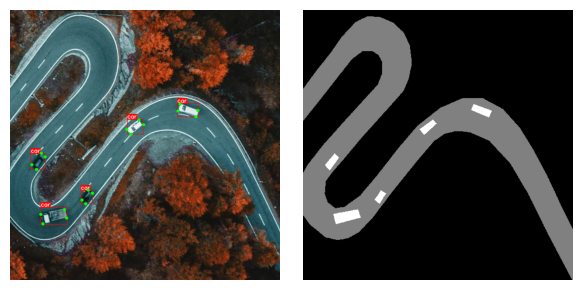

In [ ]:
visualize_one(image, bboxes, keypoints, category_ids, category_id_to_name, mask)

In [ ]:
transform = A.Compose(
    [A.CenterCrop(height=512, width=256, p=1), A.D4(p=1)],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"]),
    keypoint_params=A.KeypointParams(format="xy"),
    seed=137,
    strict=True,
)

In [ ]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids, keypoints=keypoints, mask=mask)

In [ ]:
def get_hash(image):
    image_bytes = image.tobytes()
    hash_md5 = hashlib.md5()
    hash_md5.update(image_bytes)
    return hash_md5.hexdigest()

In [ ]:
transformations_dict = {}

for _ in range(80):
    transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids, keypoints=keypoints, mask=mask)
    image_hash = get_hash(transformed["image"])

    if image_hash in transformations_dict:
        transformations_dict[image_hash]["count"] += 1
    else:
        transformations_dict[image_hash] = {
            "count": 1,
            "transformed": transformed,
        }

The transform generates all 8 possible variants with the same probability, including identity transform

In [ ]:
len(transformations_dict)

8

In [ ]:
for key in transformations_dict:
    print(key, transformations_dict[key]["count"])

7c795aa3b49e3e6ddc8aa88b8733e722 10
28b177074878fe87574650377c205697 10
c714bc2f34652f4602086e7e40ae220d 8
ea0eff187cd3ace9958c4a5816352cd0 12
c085441d5d9caf2f023ecf00d110128b 8
9ab005fad5fc545fe637d9fa6e8f61a6 10
a47ceaaf314a159365c0092867e881e6 10
6f6b1cbc99952ed23a35516925a5f674 12


In [ ]:
transformed_list = [value["transformed"] for value in transformations_dict.values()]

In [ ]:
images = [x["image"] for x in transformed_list]
masks = [x["mask"] for x in transformed_list]
bboxes_list = [x["bboxes"] for x in transformed_list]
keypoints_list = [x["keypoints"] for x in transformed_list]


category_ids_list = [[1] * len(x["bboxes"]) for x in transformed_list]
category_id_to_name = {1: "car"}

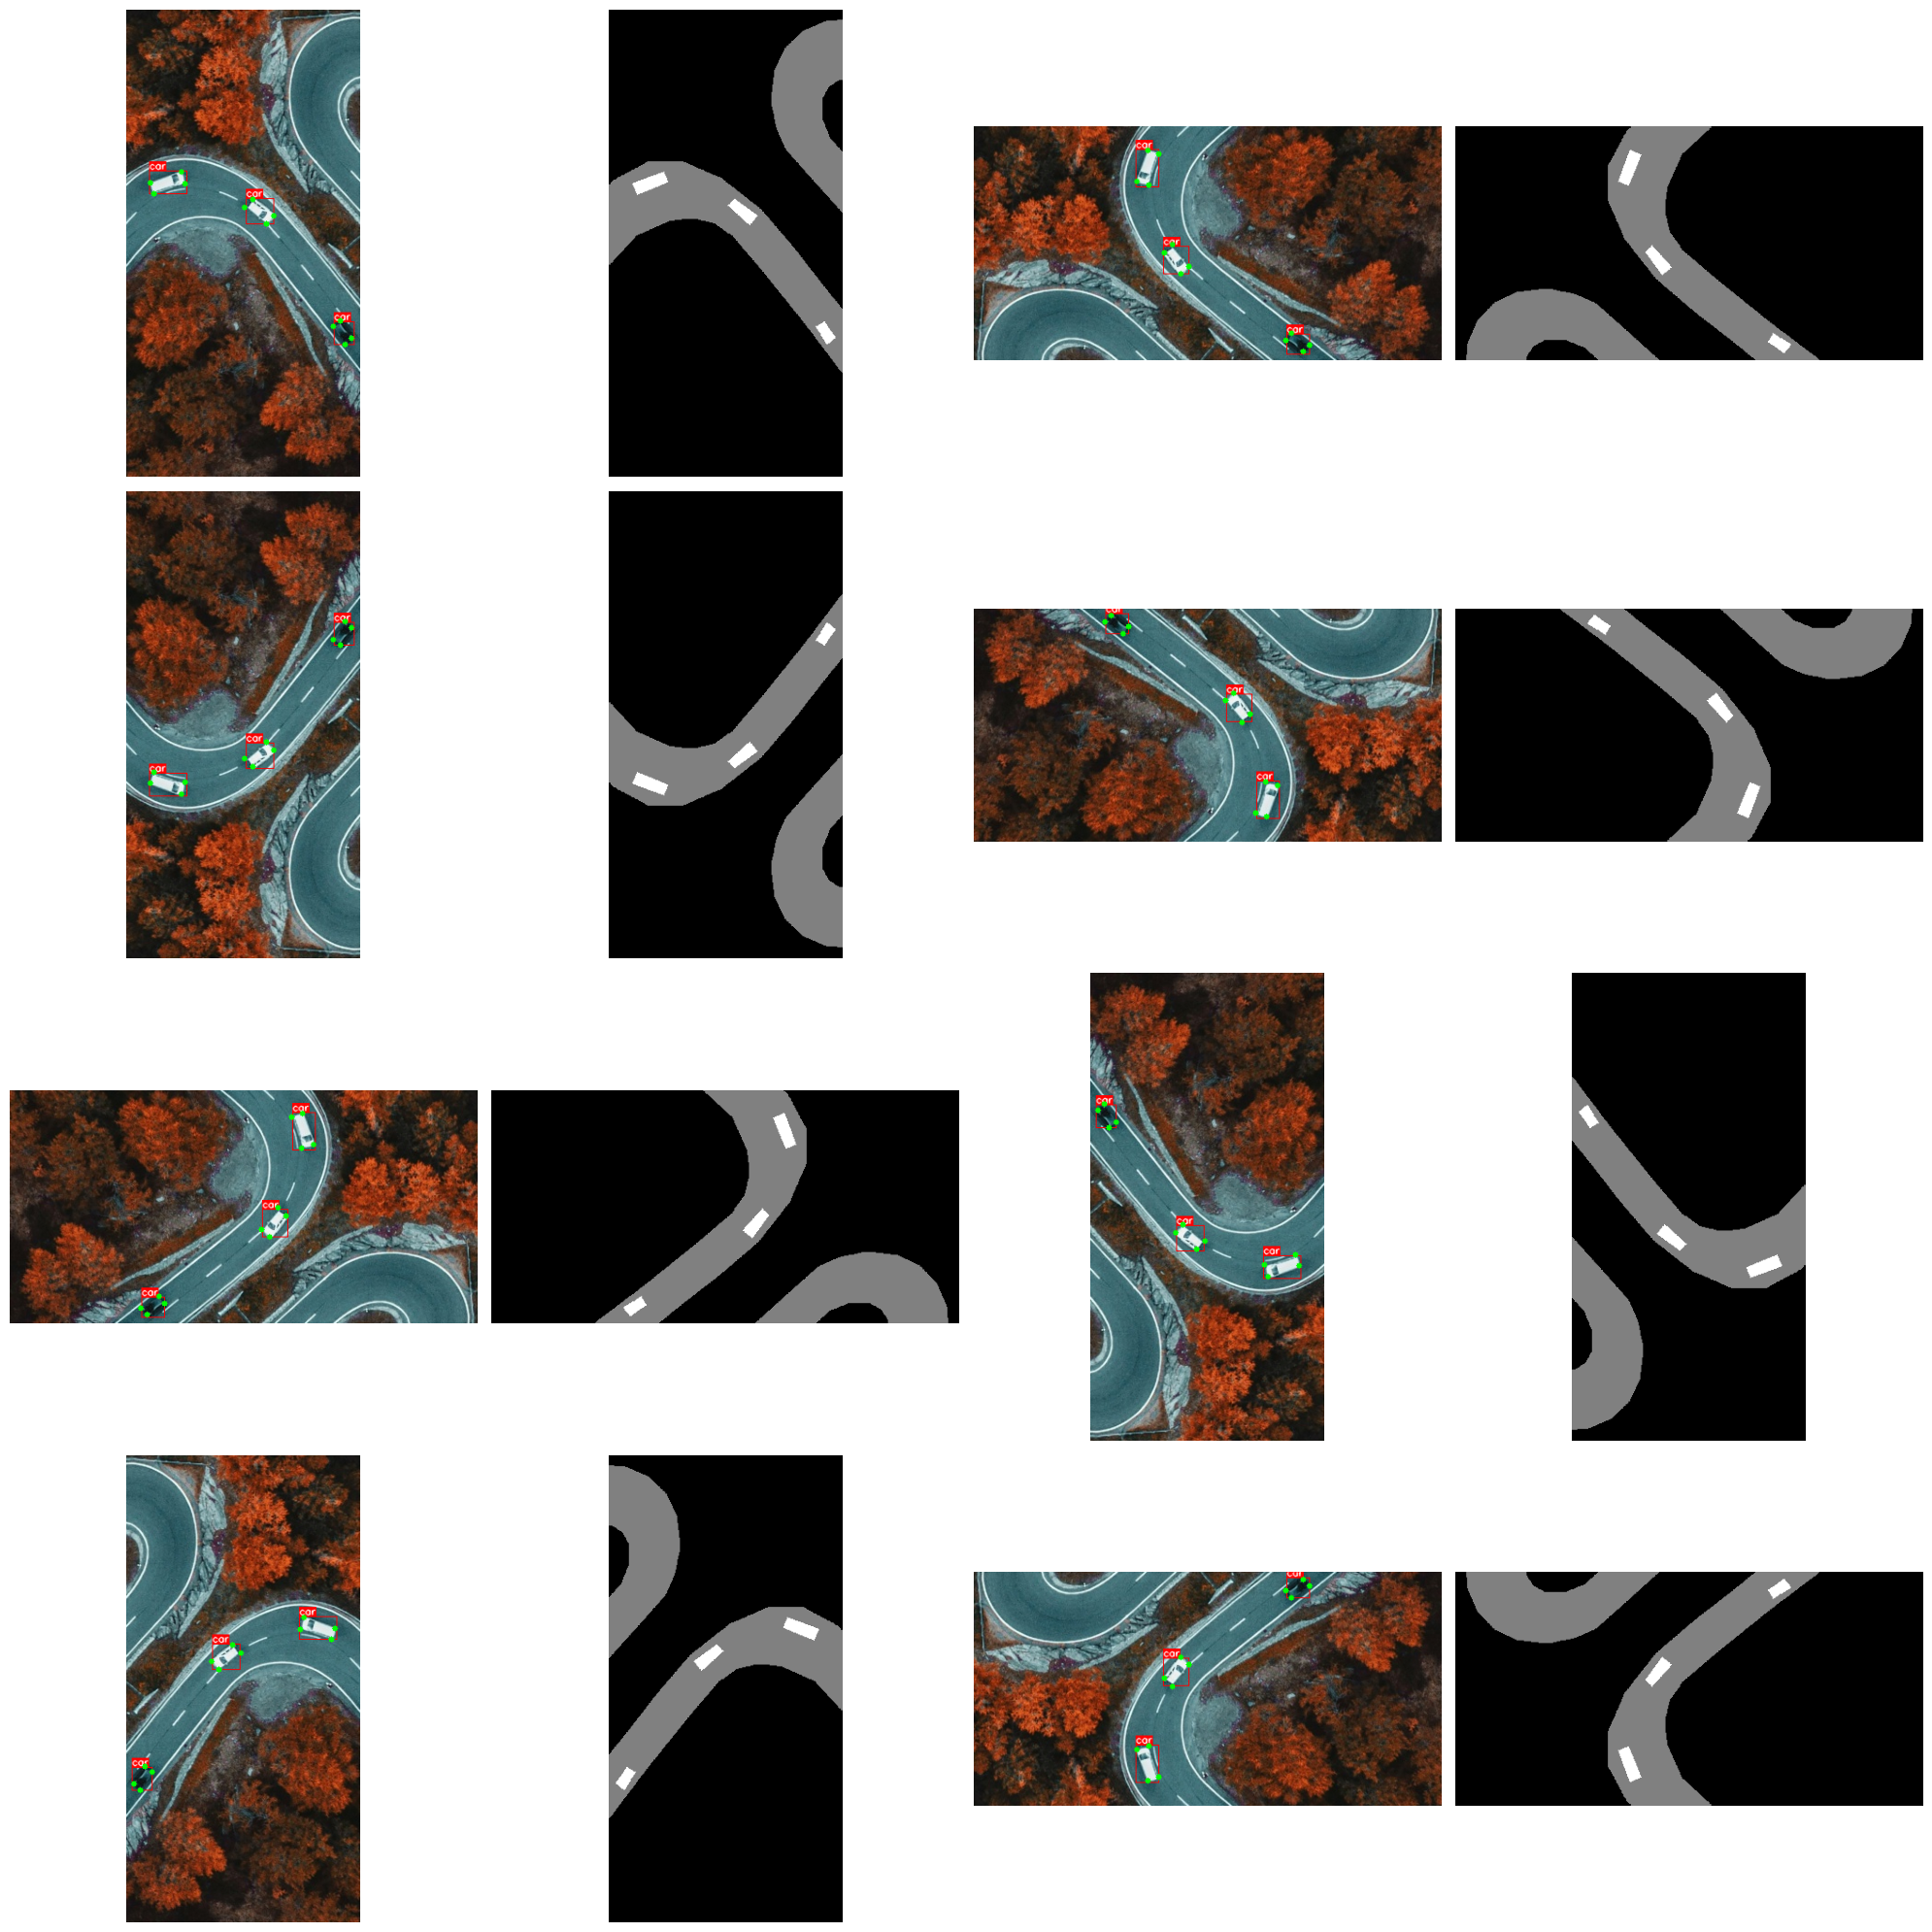

In [ ]:
visualize(images, bboxes_list, keypoints_list, category_ids_list, category_id_to_name, masks)